In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csgraph, coo_array
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx
from affinis.utils import _sq, _norm_diag


In [2]:
df=pd.read_csv(
    '../data/High-School_data_2013.csv', 
    sep=' ', header=None, index_col=None,# infer_datetime_format=True, 
    names=['timestamp','source', 'target', 'cls_source', 'cls_target'],
    parse_dates=['timestamp']
).assign(
    timestamp=lambda df: pd.to_datetime(df['timestamp'], origin='unix', unit='s'),
    source=lambda df: 'S'+df['source'].astype(str),
    target=lambda df:'S'+df['target'].astype(str)
)
df=(
    df
    .astype({
        'source':(student_idx:=pd.CategoricalDtype(categories=(students:=sorted(set(df.source)|set(df.target))))),
        'target': student_idx,
    })
# .astype({'source':student_idx.dtype, 'target':student_idx.dtype}) 
    # .set_index('timestamp')
    .assign(edge=(df.source.astype(str)+','+(
        df.target.astype(str)).str.split(',')
        .apply(set).apply(tuple)
        .apply(lambda s:','.join(s))
        .values
        ),
        pairclass = df.cls_source.where(df.cls_source==df.cls_target, 'hallway')
    )
)
# student_idx = pd.CategoricalIndex(students)
# student_idx.categories
# (df.source.astype(str)+','+df.target.astype(str)).str.split(',').apply(set).apply(sorted).values
# ((df.cls_source==df.cls_target)).sum()
df

,timestamp,source,target,cls_source,cls_target,edge,pairclass
0,2013-12-02 11:00:20,S454,S640,MP,MP,"S454,S640",MP
1,2013-12-02 11:00:20,S1,S939,2BIO3,2BIO3,"S1,S939",2BIO3
2,2013-12-02 11:00:20,S185,S258,PC*,PC*,"S185,S258",PC*
3,2013-12-02 11:00:20,S55,S170,2BIO3,2BIO3,"S55,S170",2BIO3
4,2013-12-02 11:00:20,S9,S453,PC,PC,"S9,S453",PC
...,...,...,...,...,...,...,...
188503,2013-12-06 15:59:20,S120,S285,PC,PC,"S120,S285",PC
188504,2013-12-06 15:59:40,S61,S160,2BIO2,2BIO2,"S61,S160",2BIO2
188505,2013-12-06 15:59:40,S272,S939,2BIO3,2BIO3,"S272,S939",2BIO3
188506,2013-12-06 15:59:40,S311,S496,PC,PC,"S311,S496",PC


In [3]:
# df.set_index(['timestamp','pairclass']).sort_index()#.assign(flag=1)['flag'].unstack(level='source')#.groupby(['timestamp', 'pairclass'])#['source']#.size().to_frame()
contact_src = coo_array((np.ones_like(df.index.values), (df.index.values, df.source.cat.codes)), shape=(df.shape[0],student_idx.categories.shape[0]))
contact_tgt = coo_array((np.ones_like(df.index.values), (df.index.values, df.target.cat.codes)), shape=(df.shape[0],student_idx.categories.shape[0]))
contacts = contact_tgt - contact_src

/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


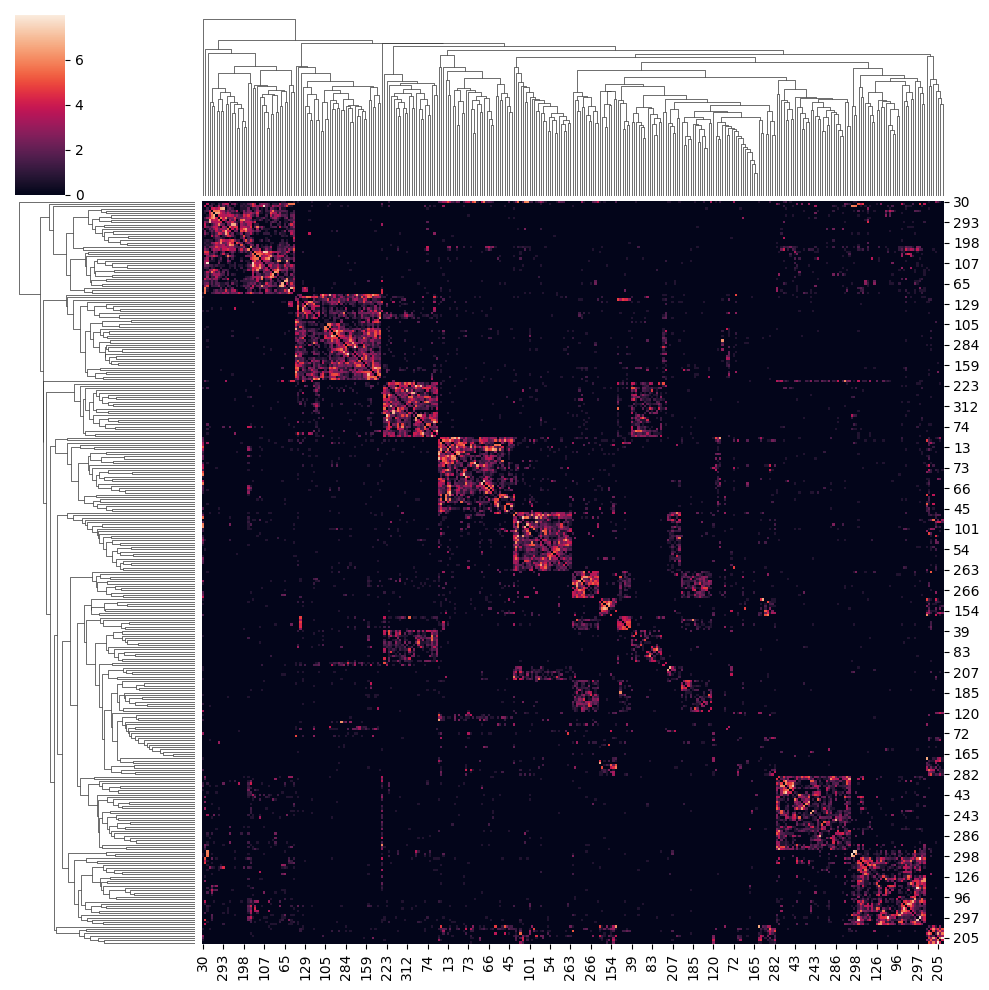

In [4]:
from matplotlib.colors import LogNorm
sns.clustermap(
    np.log(_sq(_sq(-(contacts.T@contacts).todense()))+1),
    # norm=LogNorm()
    # cbar_kws={"ticks":[0,1,10,1e2,1e3,1e4,1e5]})
# (contacts.T@contacts).todense()
)


In [125]:
# sns.histplot()
# df.groupby(['timestamp', 'pairclass']).count().edge
source_occ = df.groupby(['pairclass','source']).resample('30T', on='timestamp')['edge'].count().unstack(level='source').fillna(0)#.mean()#.groupby('edge').count()
target_occ = df.groupby(['pairclass','target']).resample('30T', on='timestamp')['edge'].count().unstack(level='target').fillna(0)#.mean()#.groupby('edge').count()
source_occ

source                         S111  S124  S145  S177   S28  S400  S428  S443  \
pairclass timestamp                                                             
2BIO1     2013-12-02 11:00:00  25.0   7.0   7.0  27.0   0.0  14.0   2.0  45.0   
          2013-12-02 11:30:00   0.0   5.0   0.0  56.0   0.0   1.0   0.0   0.0   
          2013-12-02 12:00:00   4.0   0.0   0.0  41.0   0.0   8.0   5.0   0.0   
          2013-12-02 12:30:00  66.0   6.0   6.0  10.0   0.0   7.0   2.0   0.0   
          2013-12-02 13:00:00  25.0  12.0   5.0  41.0  47.0  25.0   0.0   1.0   
...                             ...   ...   ...   ...   ...   ...   ...   ...   
hallway   2013-12-06 13:00:00   0.0   0.0   0.0   0.0  10.0   0.0   0.0   0.0   
          2013-12-06 13:30:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
          2013-12-06 14:00:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
          2013-12-06 14:30:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
          2013-12-06 15:00:00   0.0   2.0   0.0   0.0   4.0   0.0   0.0   0.0   

source                         S465  S471  ...  S920  S921  S874  S908  S941  \
pairclass timestamp                        ...                                 
2BIO1     2013-12-02 11:00:00   4.0  15.0  ...   0.0   0.0   0.0   0.0   0.0   
          2013-12-02 11:30:00   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   
          2013-12-02 12:00:00   7.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   
          2013-12-02 12:30:00   7.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   
          2013-12-02 13:00:00  13.0   1.0  ...   0.0   0.0   0.0   0.0   0.0   
...                             ...   ...  ...   ...   ...   ...   ...   ...   
hallway   2013-12-06 13:00:00   0.0   0.0  ...   5.0   0.0   0.0   0.0   0.0   
          2013-12-06 13:30:00   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   
          2013-12-06 14:00:00   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   
          2013-12-06 14:30:00   0.0   1.0  ...   0.0   0.0   0.0   0.0   0.0   
          2013-12-06 15:00:00   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   

source                         S958  S960  S974  S977  S979  
pairclass timestamp                                          
2BIO1     2013-12-02 11:00:00   0.0   0.0   0.0   0.0   0.0  
          2013-12-02 11:30:00   0.0   0.0   0.0   0.0   0.0  
          2013-12-02 12:00:00   0.0   0.0   0.0   0.0   0.0  
          2013-12-02 12:30:00   0.0   0.0   0.0   0.0   0.0  
          2013-12-02 13:00:00   0.0   0.0   0.0   0.0   0.0  
...                             ...   ...   ...   ...   ...  
hallway   2013-12-06 13:00:00   0.0   0.0   0.0   0.0   0.0  
          2013-12-06 13:30:00   0.0   0.0   0.0   0.0   0.0  
          2013-12-06 14:00:00   0.0   0.0   0.0   0.0   0.0  
          2013-12-06 14:30:00   0.0   0.0   0.0   0.0   0.0  
          2013-12-06 15:00:00   0.0   0.0   0.0   0.0   0.0  

[2019 rows x 320 columns]

/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


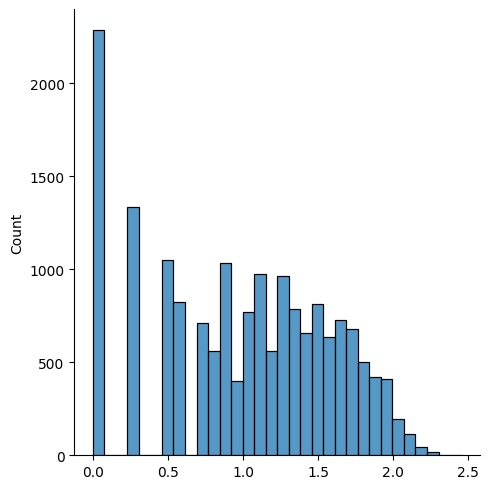

In [137]:
# (source_occ+target_occ)
# source_occ.T.reindex_like(student_idx, fill_value=0.).T
# pd.merge(source_occ/unstack(), target_occ)
# pd.merge(source_occ, target_occ, how='outer')
co_occ = coo_array(
    (
        (src_sprs:=coo_array(source_occ.values)).data,
        (src_sprs.row, source_occ.columns.codes[src_sprs.col])
    ), shape=(source_occ.shape[0], student_idx.categories.size)
)+ coo_array(
    (
        (tgt_sprs:=coo_array(target_occ.values)).data,
        (tgt_sprs.row, target_occ.columns.codes[tgt_sprs.col])
    ), shape=(target_occ.shape[0], student_idx.categories.size)
).todense()
sns.displot(np.ma.log10(co_occ.flat))
co_occ[co_occ<10] = 0
co_occ = co_occ[co_occ.max(axis=1)>0,:]
co_occ[co_occ>=10] = 1
# co_occ.max(axis=0)


In [138]:
co_occ

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<Axes: ylabel='Density'>

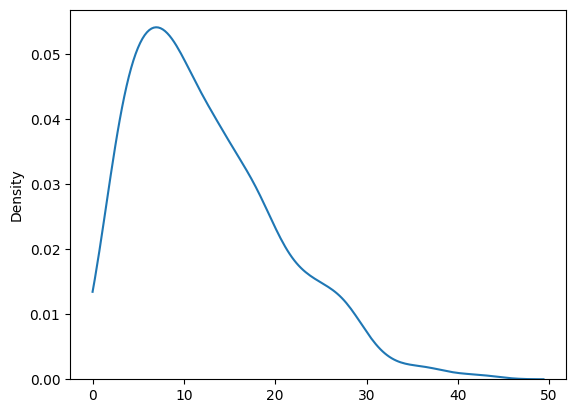

In [139]:
sns.kdeplot(np.sum(co_occ,axis=1), clip=(0,None))

/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


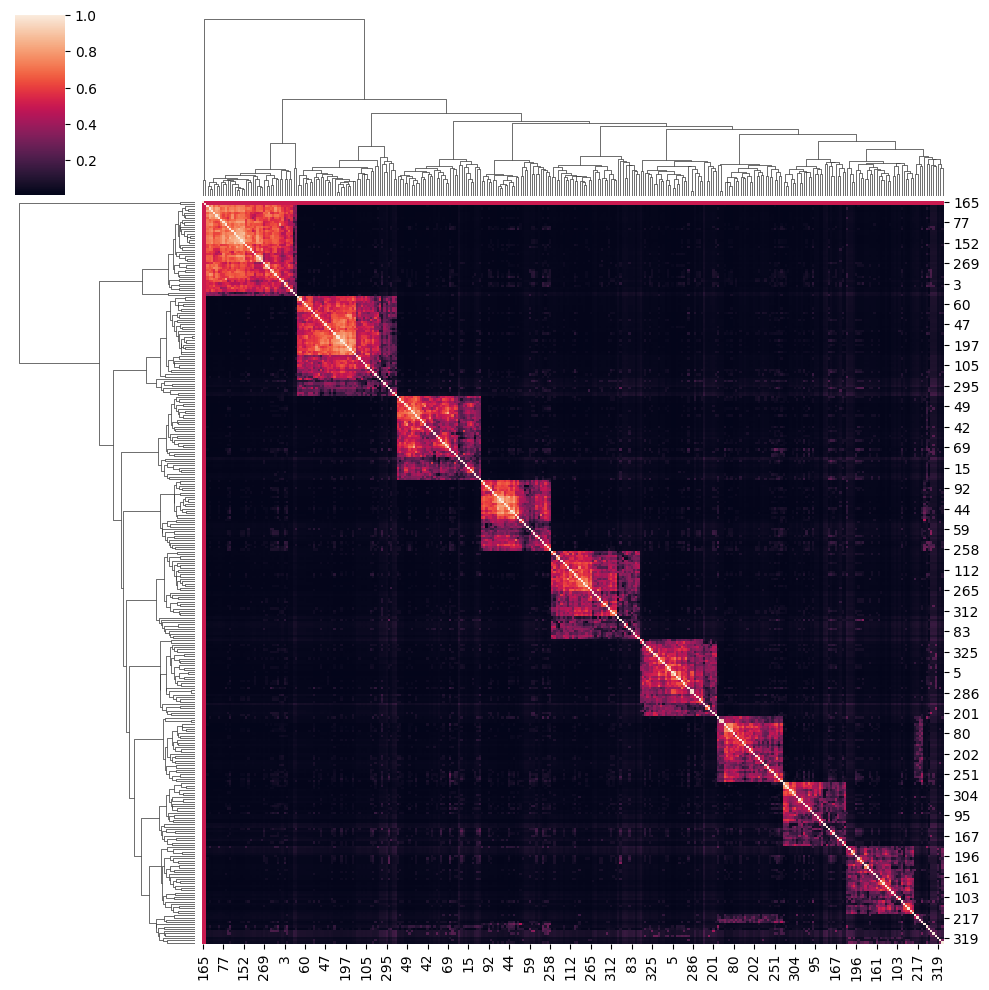

In [140]:
from affinis.associations import ochiai
# sns.clustermap(ochiai(co_occ, pseudocts=0.))
sns.clustermap(ochiai(co_occ, pseudocts=0.5))

In [106]:
# df_hr=(
#     df.groupby(['class','edge')
#     .resample('1D').count()['source']
#     .rename('count')
#     # .reset_index().set_index('timestamp').sort_index()
#     #.dropna(subset='source')
# )
# df_hr

In [107]:
# roll_B,_,_=df_hr.groupby(['timestamp', 'edge']).mean().astype(pd.SparseDtype(int, fill_value=0)).sparse.to_coo()
# # plt.figure(figsize=(10,10))
# # plt.spy(roll_B.T, marker='|', aspect=1/1000)
# roll_B.mean(axis=0), roll_B.toarray().std(axis=0)
# ## THIS IS 4 (diffusio) GRAPHS STACKED, NEED TO ROLL-UP AND MERGE

In [108]:
# df_hr.groupby('edge').mean().sort_values().reset_index().edge.str.split(',').explode()

In [109]:
# df_hr#.groupby('edge')['source'].agg(['mean','std', 'count'])
# pd.MultiIndex.from_tuples(df_hr.edge.str.split(','))

In [230]:
# df.edge.value_counts()/df.shape[0]
diaries = pd.read_csv(
    '../data/Contact-diaries-network_data_2013.csv', 
    names = ['source', 'target','weight'], 
    header=None, sep=' ', dtype={'source':str, 'target':str}
).assign(**{
        'source':lambda df: 'S'+df['source'],
        'target': lambda df:'S'+df['target']
}).astype({'source': student_idx, 'target':student_idx})
diaries.set_index(['source','target'])#.unstack()

weight
source target        
S3     S28          2
       S106         1
       S147         4
       S177         1
       S295         4
...               ...
S1828  S1237        1
       S1295        1
       S1412        1
       S1423        2
       S1594        4

[502 rows x 1 columns]

/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


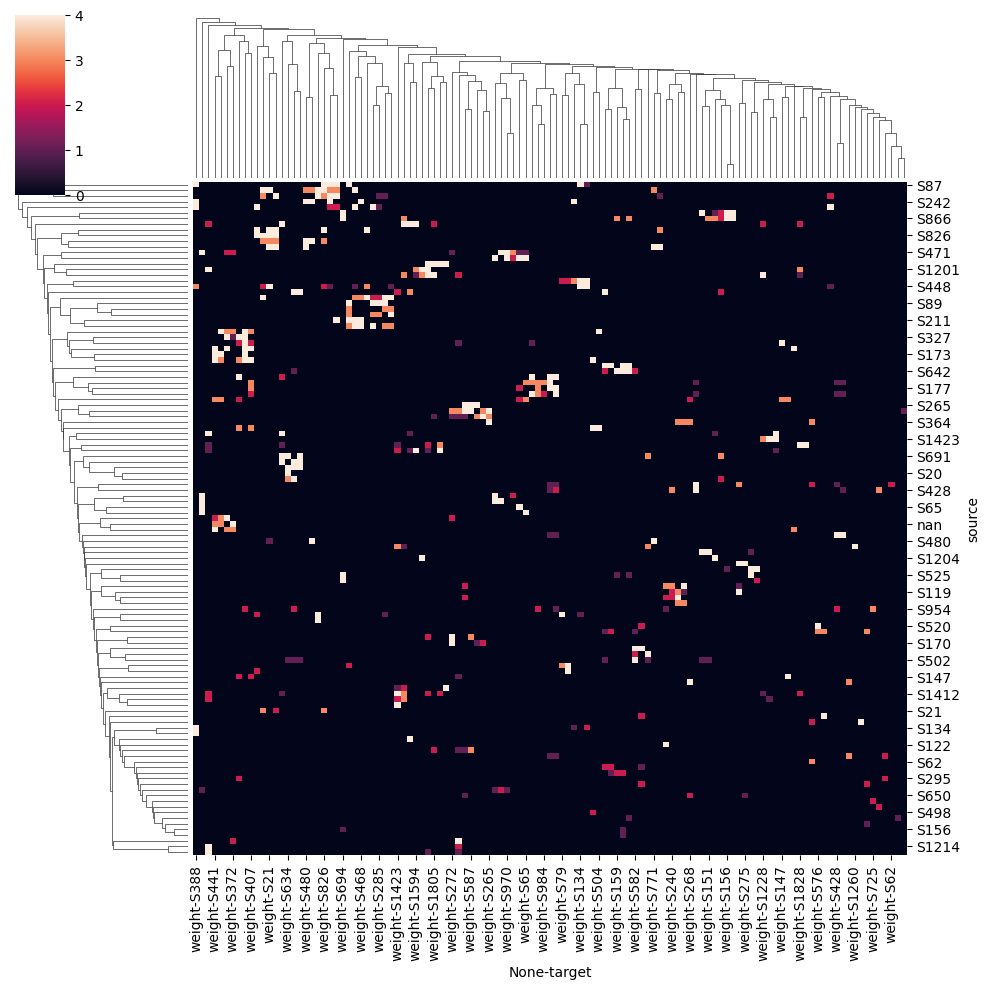

In [232]:

sns.clustermap(diaries.set_index(['source','target']).unstack().fillna(0.))

/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


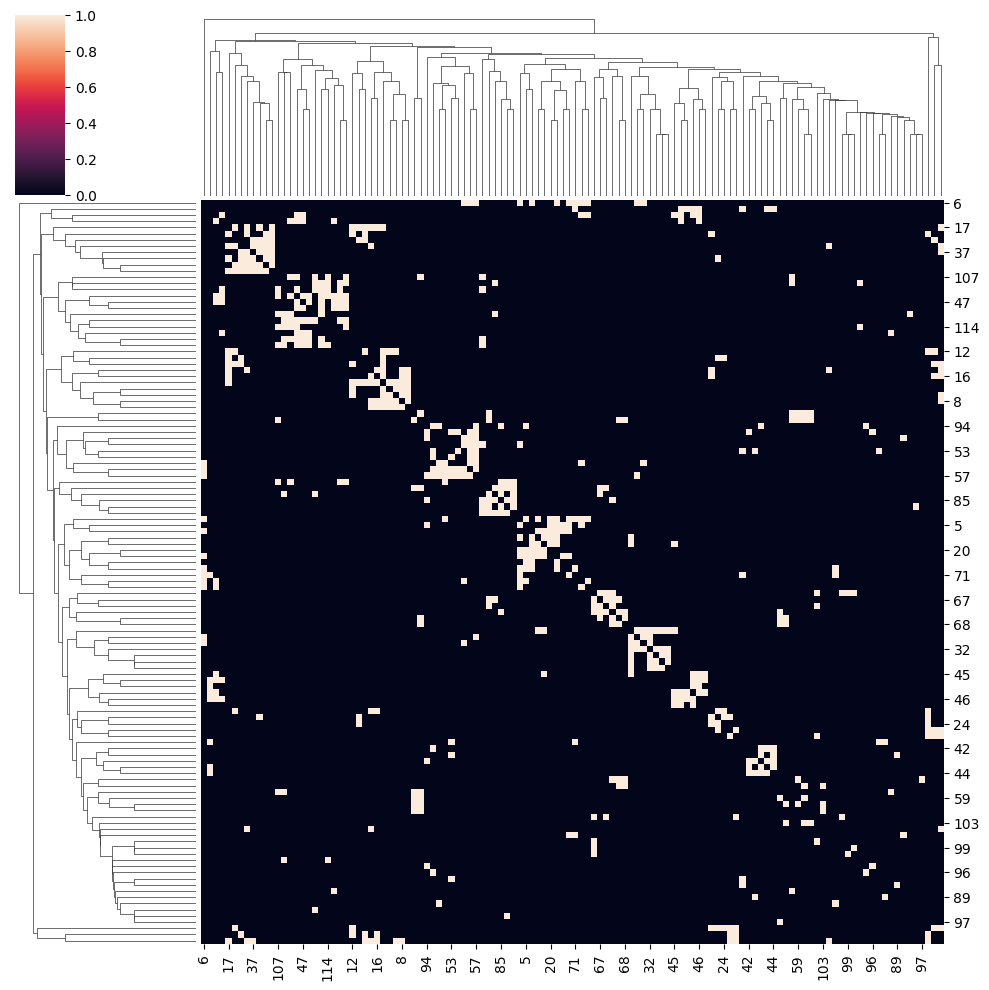

In [238]:
sns.clustermap(nx.to_numpy_array(nx.from_pandas_edgelist(diaries)))

In [141]:
friends=(
    pd.read_csv(
        '../data/Friendship-network_data_2013.csv', 
        names=['source', 'target'], header=None, sep=' '
    )
    .astype(str)
    .assign(**{
        'source':lambda df: 'S'+df['source'],
        'target': lambda df:'S'+df['target']
    })
)
# friend_type = pd.CategoricalDtype(
#     categories=sorted(set(friends['source'])|set(friends['target']))
# )
# students=sorted(set(friends['source'])|set(friends['target']))
friends=friends.astype(student_idx)
A_f = coo_array((np.ones(friends.shape[0]), (friends['source'].cat.codes, friends['target'].cat.codes)),shape=(len(students),len(students)))
# friends_idx = pd.MultiIndex.from_product([student_idx, student_idx], names=['source','target'])
# friends=(
pd.Series.sparse.from_coo(A_f)
    # friends
    # .assign(friends=True)
    # .set_index(['source','target'])
    # ['friends']
    # .astype(pd.SparseDtype('int', fill_value=0))
# )
# friends.sparse.to_coo(column_levels=friend_type.categories, row_levels=friend_type.categories)
friends

,source,target
0,S1,S55
1,S1,S205
2,S1,S272
3,S1,S494
4,S1,S779
...,...,...
663,S1519,S1828
664,S1594,S1519
665,S1594,S1828
666,S1828,S1519


/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


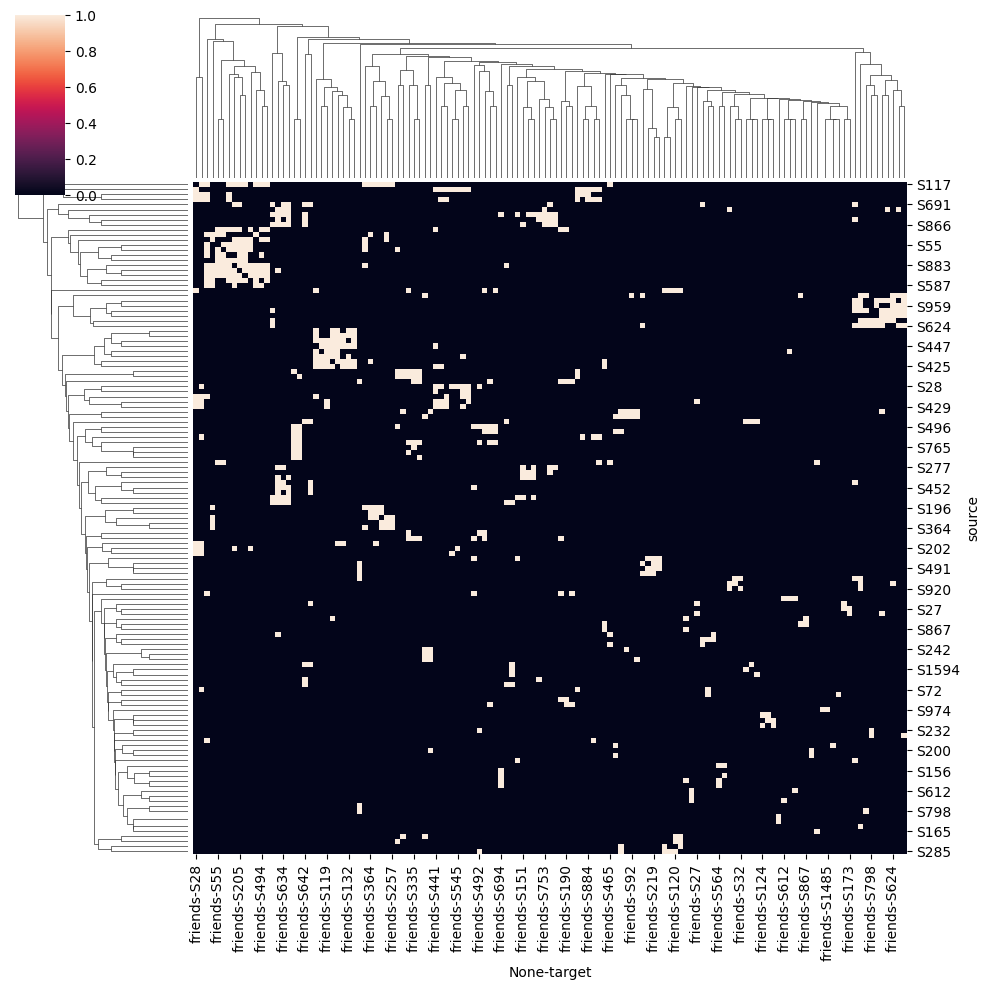

In [142]:
sns.clustermap(friends.assign(friends=1).set_index(['source','target']).unstack().fillna(0))

/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


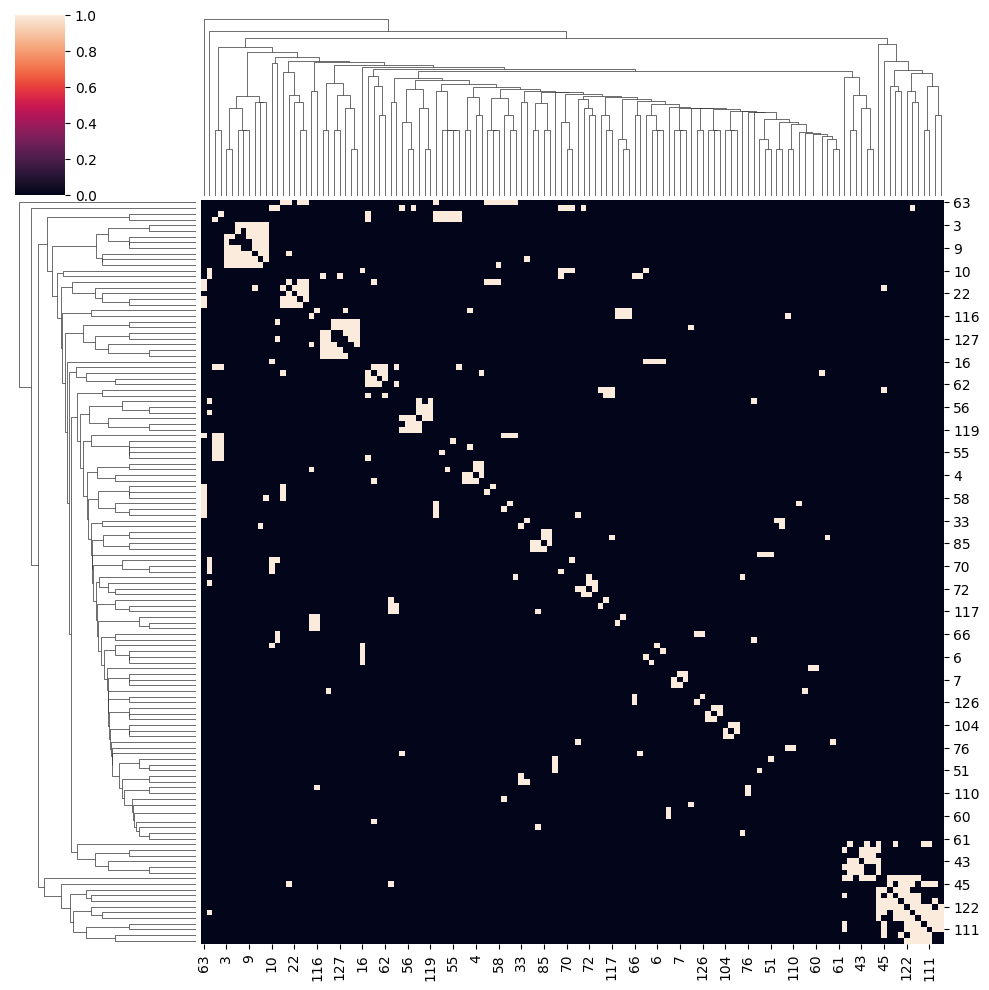

In [143]:
mask = A_f.sum(axis=0)>0
true = _sq(np.minimum(A_f.todense(), A_f.T.todense())[mask][:,mask])
sns.clustermap(_sq(true))
# A_f.todense()[mask][:,mask]

In [144]:
_sq(true)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [145]:
F=nx.from_pandas_edgelist(friends)
conn_comp = max(nx.connected_components(F), key=len)
F = F.subgraph(conn_comp)

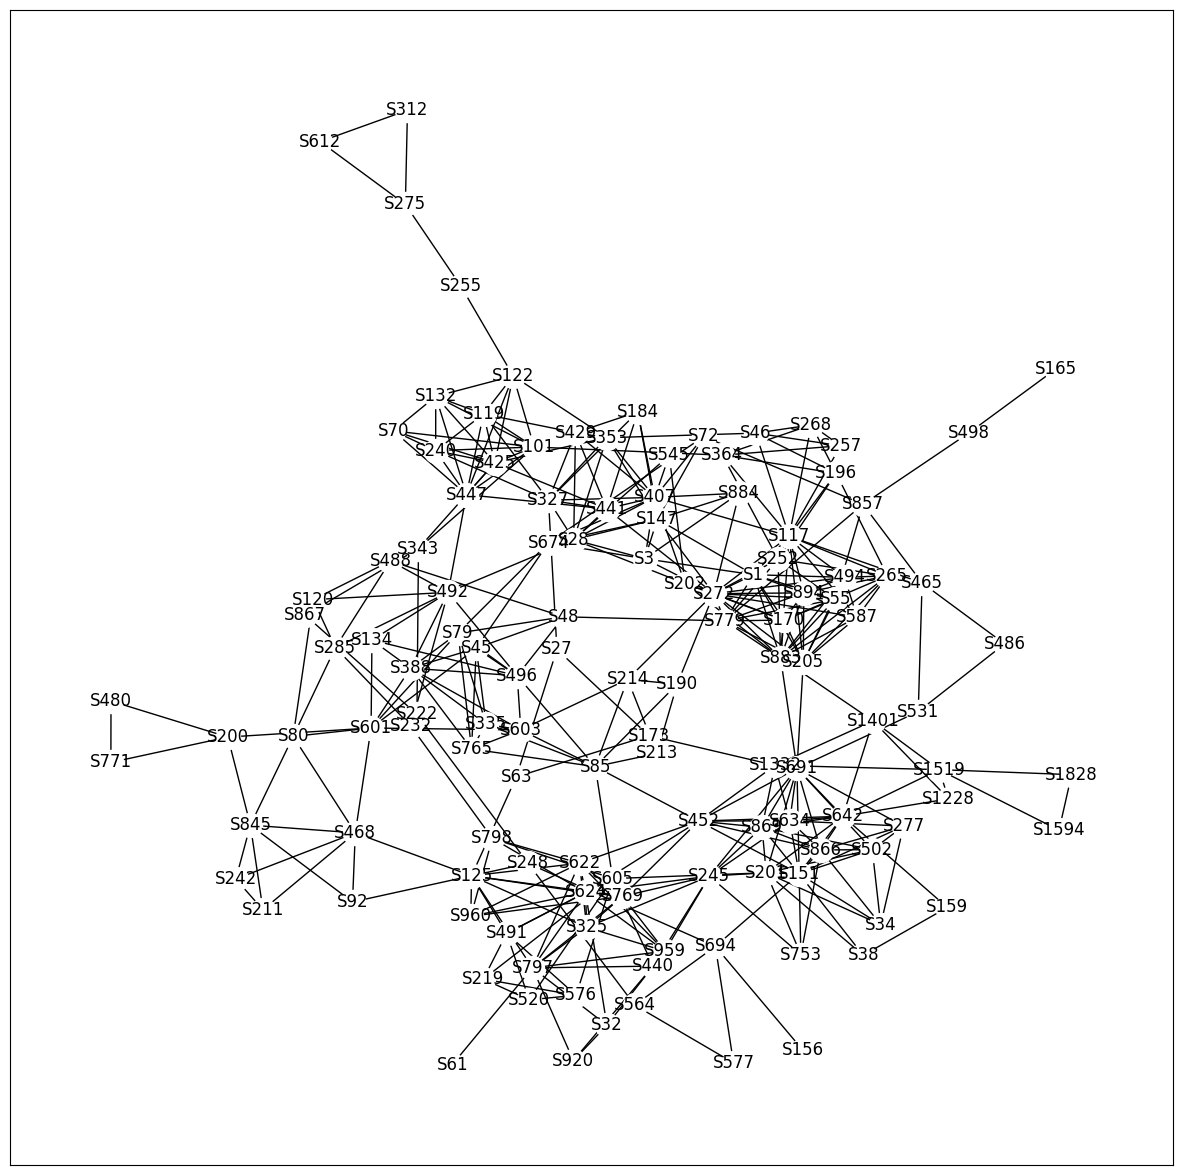

In [157]:
pos=nx.layout.kamada_kawai_layout(F,scale=10)
plt.figure(figsize=(15,15))
nx.draw_networkx(F, node_color='w', pos=pos)

In [147]:

from scipy.sparse.csgraph import minimum_spanning_tree
from affinis.distance import bilinear_dists
from affinis.proximity import sinkhorn, forest
from affinis.associations import coocur_prob

X = co_occ[:,mask]
def get_mask(e_pmf,idx):
    return coo_array(_sq(e_pmf)*np.multiply.outer(idx,idx))
# est_dists = bilinear_dists(sinkhorn(_norm_diag(coocur_prob(X, pseudocts=0.5))))
# est_dists = bilinear_dists(mutual_information(X, pseudocts=0.5))
# est_dists = -np.log(ochiai(X, pseudocts=0.5))
# est_dists = bilinear_dists(forest(_norm_diag((contacts.T@contacts).todense())))
est_dists = _sq(_sq(-np.ma.log(_norm_diag(np.abs(((contacts[:,mask].T@contacts[:,mask]).todense())))).filled(0)))

E_obs=coo_array([_sq(minimum_spanning_tree(
        get_mask(_sq(est_dists),i)
    ).todense()>0) for i in X
])



In [217]:
def adj_to_laplacian(A):
    return np.diag(A.sum(axis=0))-A
# print(adj_to_laplacian(_sq(_sq(minimum_spanning_tree(est_dists[X[0].astype(bool)][:,X[0].astype(bool)]).todense()>0))))
# bilinear_dists(forest(adj_to_laplacian(_sq(_sq(minimum_spanning_tree(est_dists[X[0].astype(bool)][:,X[0].astype(bool)]).todense()>0))), beta=0.1))/2

[[ 2 -1 -1  0  0]
 [-1  1  0  0  0]
 [-1  0  2 -1  0]
 [ 0  0 -1  2 -1]
 [ 0  0  0 -1  1]]


array([[0.        , 0.40199458, 0.3872199 , 0.41984733, 0.44016252],
       [0.40199458, 0.        , 0.43708446, 0.44016252, 0.45801527],
       [0.3872199 , 0.43708446, 0.        , 0.3872199 , 0.43708446],
       [0.41984733, 0.44016252, 0.3872199 , 0.        , 0.40199458],
       [0.44016252, 0.45801527, 0.43708446, 0.40199458, 0.        ]])

In [148]:
# E_obs.sum(axis=1)
# ochiai(contacts.todense())
(lambda A: A/np.sqrt(np.multiply.outer(np.diag(A), np.diag(A))))(((contacts.T@contacts).todense()))
# X


array([[ 1.00000000e+00, -1.28409810e-03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.28409810e-03,  1.00000000e+00,  0.00000000e+00, ...,
        -8.76806816e-04,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00, -8.76806816e-04,  0.00000000e+00, ...,
         1.00000000e+00, -1.15133969e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.15133969e-03,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [149]:
add_pmf = (E_obs.sum(axis=0)+0.5)/(E_obs.shape[0]+1)
mst_post = X.shape[0]*(E_obs.sum(axis=0)+0.5)*_sq(coocur_prob(X, pseudocts=0.5))/(_sq(X.T@X)+1)

post_L=_sq((lambda o:o/(o+1))(_sq(mst_post)/forest(_norm_diag((lambda a: np.diag(a.sum(axis=0))-a)(_sq(mst_post))), beta=10)/X.shape[0]))
# mst_post.shape, post_L.shape

In [150]:
# sns.clustermap(_sq(E_obs.sum(axis=0)>0)[mask][:,mask])
# sns.clustermap(_sq(minmax(mst_post)>0.01)[mask][:,mask])

In [151]:
# true = _sq(np.maximum(A_f.todense(), A_f.T.todense()))
from sklearn.covariance import GraphicalLasso
from affinis.associations import resource_project, chow_liu
baselines = {
    # 'co-occur':_sq(coocur_prob(X, pseudocts=1.)),
    'cosine': _sq(ochiai(X, pseudocts=0.5)),#[mask][:,mask]),
    'sinkhornOTP': _sq(sinkhorn(np.ma.log(np.abs((contacts[:,mask].T@contacts[:,mask]).todense())).filled(0), err=1e-8)),#[mask][:,mask]),
    # 'resourceProj': _sq(resource_project(X)),
    # # 'odds-ratio': _sq(odds_ratio(X, pseudocts=1)),
    # 'yuleQ':_sq(yule_q(X, pseudocts=1.)),
    # # 'yuley': prox_to_edgeprob(yule_y(X)),
    # 'mutualinfo': _sq(mutual_information(X, pseudocts=1.)),
    # # 'yuleq':np.arcsin(prox_to_edgeprob(yule_y(X)))/np.pi +0.5,
    'glasso': -_sq(GraphicalLasso(alpha=0.005).fit(X).get_precision()),
    'chow-liu':_sq((chow_liu(X, pseudocts=0.5)>0.).astype(int)), 
    # 'interact': np.log(_sq(-(contacts.T@contacts).todense()[mask][:,mask])+1),
    'interact_norm':_sq(-_norm_diag((contacts[:,mask].T@contacts[:,mask]).todense())),
    'MST_e' : _sq(_sq(post_L)),#[mask][:,mask]),
    'MST_i' : _sq(_sq(mst_post)),#[mask][:,mask]),
    # 'MST_s' : _sq(sinkhorn(_sq(post_L)))#[mask][:,mask])),
    # 'MST_sum': E_obs.sum(axis=0)

    # 'sinkhorn-cos': _squareform(sinkhorn(cos - np.diag(np.diag(cos)), err=1e-8)),
}
true.shape, baselines['cosine'].shape

((8515,), (8515,))

In [152]:
# np.sort(_sq(_sq(post_L)[mask][:,mask]))
_sq(baselines['glasso'])

array([[ 0.        ,  0.        ,  3.82614749, ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.        ,  4.55645902, ..., -0.        ,
        -0.        , -0.        ],
       [ 3.82614749,  4.55645902,  0.        , ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        , -0.        , ...,  0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
         0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        ,  0.        ]])

cosine: 		 8.35       0.30 	      0.35
sinkhornOTP: 		 2.93       0.58 	      0.58
glasso: 		 3.40       0.34 	      0.33
chow-liu: 		 1.00       0.30 	      0.30
interact_norm: 		 3.97       0.55 	      0.56
MST_e: 		 2.40       0.51 	      0.49
MST_i: 		 3.04       0.47 	      0.47


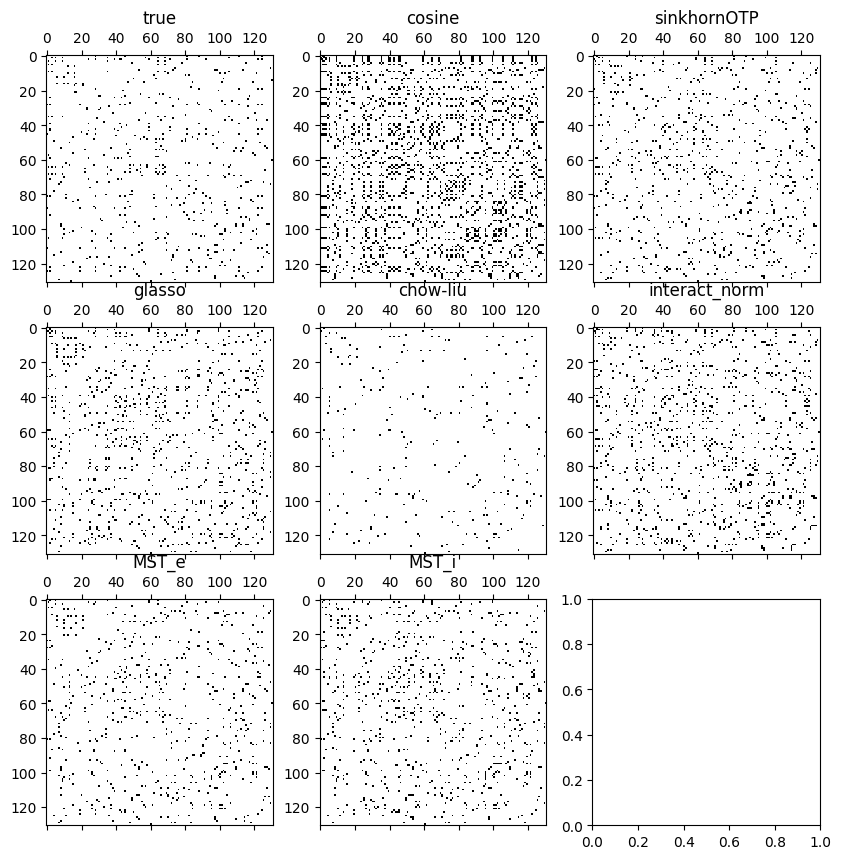

In [154]:
from affinis.utils import edge_mask_to_laplacian
# from affinis.metrics import f_beta
from sklearn.metrics import f1_score, precision_score, recall_score,matthews_corrcoef
# def edge_mask_laplacian(e):
#     n = int((np.sqrt(8*e.shape[0]+1)+1)//2)
#     print(n)
#     lap=np.ma.zeros((n,n))
#     lap[np.triu_indices(n, k=1)]=e.mask.astype(int)
#     # lap[np.tril_indices(n, k=-1)]=np.tril_indices(lap.T)
#     lap = lap+lap.T
#     lap[np.diag_indices(n)] = -np.sum(lap, axis=0)
#     return -lap
# # # coo_array((np.ones_like(),edge_mask_laplacian(np.ma.masked_less(mst_post, 0.4)).nonzero()))#[np.diag_indices(10)]#(np.ones((10,10)))]
from scipy.sparse.linalg import eigsh

from affinis.filter import min_connected_filter, check_connected
f,ax = plt.subplots(nrows=3,ncols=3, figsize=(10,10))
min_thres = baselines.copy()
ax.flatten()[0].spy(_sq(true))
ax.flatten()[0].set_title('true')
for n,(lab, Aest) in enumerate(baselines.items()):
    e = ~(min_connected_filter(Aest+1)-1).mask
    min_thres[lab] = e
    print(f'{lab}: \t\t{e.sum()/(_sq(Aest).shape[0]-1):>5.02f} {f1_score(true, e):>10.02f} \t{matthews_corrcoef(true, e):>10.02f}')
    ax.flatten()[n+1].spy(_sq(e))
    ax.flatten()[n+1].set_title(lab)

[False  True False ... False False False]
cosine: 		 1.00       0.39 	      0.38
[False False False ... False False False]
sinkhornOTP: 		 1.00       0.64 	      0.64
[False False False ... False False False]
glasso: 		 0.02       0.00 	     -0.00
[False False False ... False False False]
chow-liu: 		 0.00       0.00 	      0.00
[False False False ... False False False]
interact_norm: 		 1.00       0.74 	      0.74
[False False False ... False False False]
MST_e: 		 1.00       0.67 	      0.67
[False False False ... False False False]
MST_i: 		 0.00       0.00 	      0.00


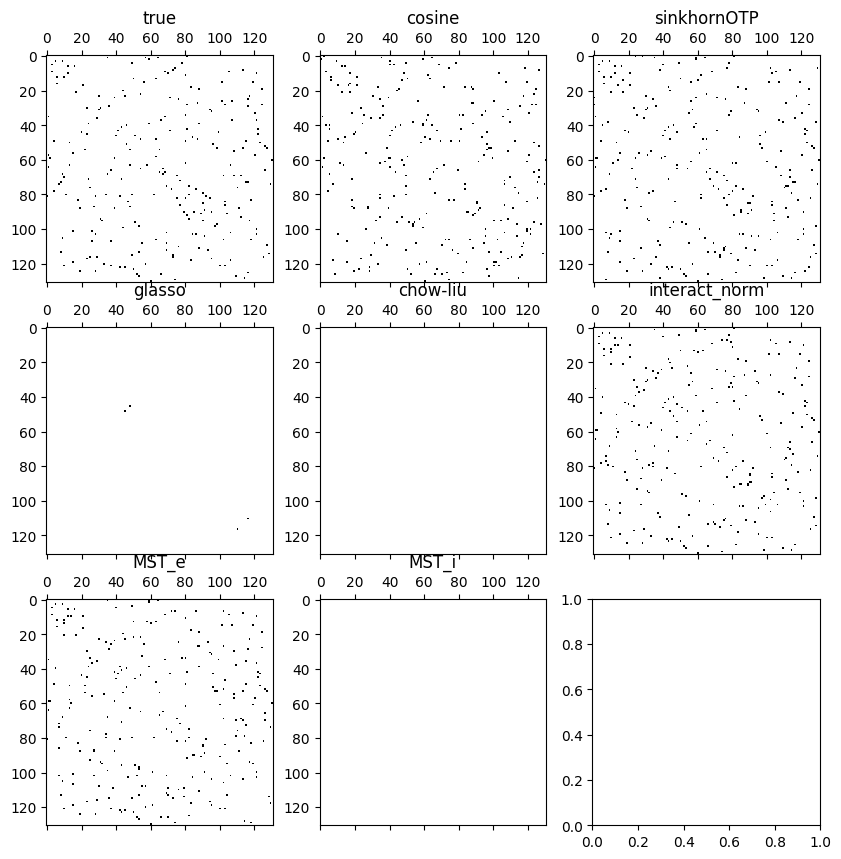

In [185]:
f,ax = plt.subplots(nrows=3,ncols=3, figsize=(10,10))
tree_thres = baselines.copy()
true_tree = _sq(minimum_spanning_tree(_sq(-np.ma.log(true*baselines['interact_norm']))).todense())>0
ax.flatten()[0].spy(_sq(true_tree))
ax.flatten()[0].set_title('true')

for n,(lab, Aest) in enumerate(baselines.items()):
    e = _sq(minimum_spanning_tree(-np.ma.log(_sq(Aest))).todense())>0
    print(e)
    tree_thres[lab] = e
    
    print(f'{lab}: \t\t{e.sum()/(_sq(Aest).shape[0]-1):>5.02f} {f1_score(true_tree, e):>10.02f} \t{matthews_corrcoef(true_tree, e):>10.02f}')
    ax.flatten()[n+1].spy(_sq(e))
    ax.flatten()[n+1].set_title(lab)

In [193]:
# bilinear_dists(forest(_norm_diag((contacts.T@contacts).todense())[mask][:,mask]))
# from numpy import ma

# _sq(_sq(-np.ma.log(_norm_diag(np.abs(((contacts.T@contacts).todense())))).filled(0)))
# sns.clustermap(_sq(tree_thres['MST_e']))
len(list(nx.community.girvan_newman(F)))

127

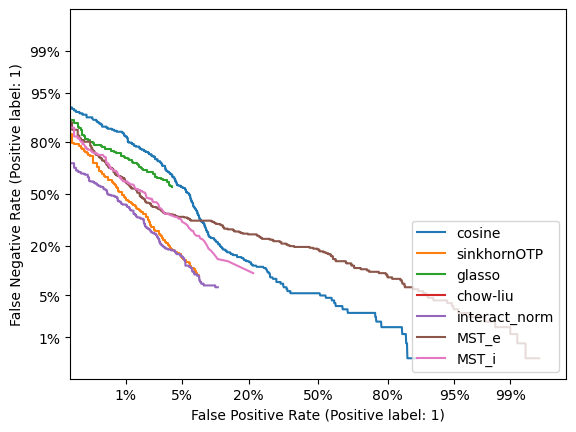

In [173]:
from sklearn.metrics import PrecisionRecallDisplay, DetCurveDisplay

for lab,Aest in baselines.items():
    # PrecisionRecallDisplay.from_predictions(true, Aest, name=lab, ax=plt.gca())    
    DetCurveDisplay.from_predictions(true, Aest, name=lab, ax=plt.gca())    

		 E[F_0.5]	 E[MCC] 	 Hell. Dist. 	 Avg P
cosine    	      0.23	      0.27	      0.13	      0.29
sinkhornOTP	      0.26	      0.27	      0.04	      0.60
glasso    	      0.19	      0.20	      0.10	      0.33
interact_norm	      0.29	      0.27	      0.03	      0.67
MST_e     	      0.39	      0.37	      0.17	      0.46
MST_i     	      0.29	      0.27	      0.04	      0.50


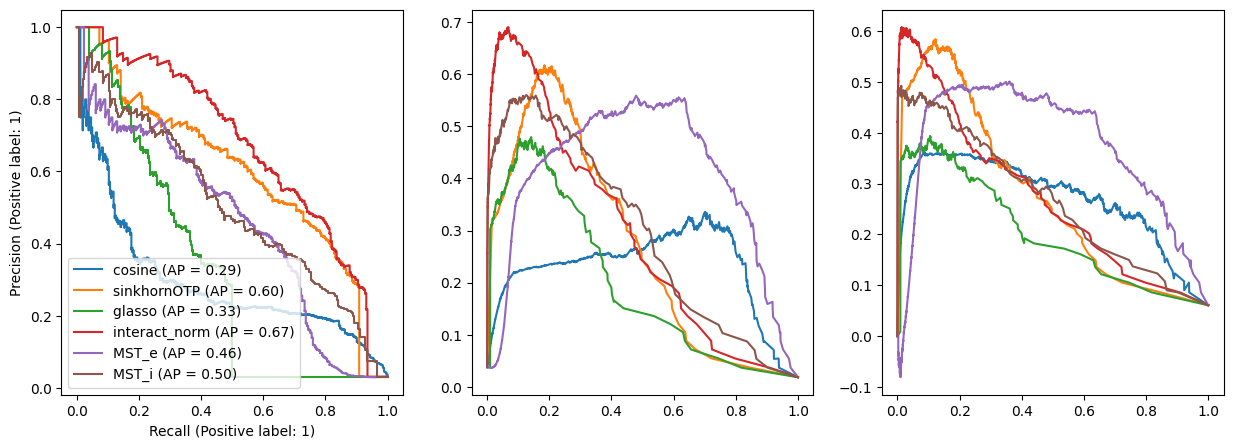

In [90]:
from sklearn.metrics import matthews_corrcoef, average_precision_score, precision_recall_curve
from cycler import cycler
# from scipy.stats import multivariate_normal, beta
from scipy import stats
from scipy.interpolate import interp1d
from affinis.metrics import f_beta

from scipy.integrate import trapezoid,cumulative_trapezoid
def binary_hellinger(a,b):
    return np.sqrt(1-(np.sqrt(a*b)+np.sqrt((1-a)*(1-b))))
def minmax(x, axis=None): 
    return np.subtract(x,x.min(axis=axis))/np.subtract(x.max(axis=axis),x.min(axis=axis))
def zscore(x):
    return (x-x.mean())/x.std()
def thres_expect(dist, x_thres, score):
    return dist.expect(interp1d(x_thres,score, bounds_error=False, kind='next'))
def human_thres_expect(x_thres, score):
    # return 0.5*thres_expect(stats.beta(0.5,0.5),x_thres, score)+0.5*thres_expect(stats.beta(2.5,1.7),x_thres,score)
    # return thres_expect(stats.beta(2.5,1.7), x_thres,score)
    return trapezoid(score, x=x_thres)
    
# baselines['MST_e'] = _sq(post_L)
# baselines['MST_i'] = mst_post

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15,5))
# fig.add_subplot(
cmap = plt.get_cmap("tab10")

color_cyc = cycler(color=[cmap(i) for i in range(len(baselines))])
cyc =  color_cyc*cycler(linestyle=['-','--'])
ax1.set_prop_cycle(cyc)
ax0.set_prop_cycle(color_cyc)

beta = 0.5
print(f'\t\t E[F_{beta}]\t E[MCC] \t Hell. Dist. \t Avg P')

for n,(lab,Aest) in enumerate(baselines.items()):
    p,r,t = precision_recall_curve(true, Aest, drop_intermediate=True)
    
    # ax0.plot(r,p, label=lab, lw=2)

    PrecisionRecallDisplay.from_predictions(true, Aest, name=lab, ax=ax0)    
    # ax1.plot(minmax(t),np.array([p[:-1],r[:-1]]).T, lw=2, label='precision', alpha=0.2)
    x_thres = np.append(minmax(t), 1.01)
    mcorr = [matthews_corrcoef(true, minmax(Aest)>=i) for i in x_thres]
    print(
        f'{lab:<10}'
        f'\t{human_thres_expect(x_thres, f_beta(beta,p,r)):>10.2f}'
        f'\t{human_thres_expect(x_thres, mcorr):>10.2f}'
        # f'\t{np.sqrt(np.dot(true-minmax(Aest), true-minmax(Aest))):>10.2f}'
        f'\t{binary_hellinger(true, minmax(Aest)).mean():>10.2f}'
        f'\t{average_precision_score(true, Aest):>10.2f}'
    )

    ax1.plot(x_thres[:-1], f_beta(beta, p,r)[:-1], color=cmap(n), ls='-', label=lab)
    ax2.plot(x_thres[:-1], mcorr[:-1], color=cmap(n), ls='-', label=lab)
    # ax1.plot(x_thres, cumulative_trapezoid(f_beta(beta, p,r), x=x_thres, initial=0.), 
    #          color=cmap(n), ls='-', label=lab)
    # ax2.plot(x_thres, cumulative_trapezoid(mcorr, x=x_thres, initial=0.), 
    #          color=cmap(n), ls='-', label=lab)


# improve_legend(ax1)
# improve_legend(ax2)

In [31]:
# sns.kdeplot(E_obs.sum(axis=0), clip=(,None))
E_obs.sum(axis=0).max()

165

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

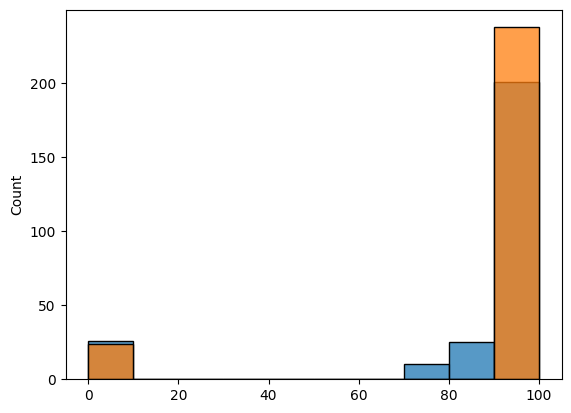

In [158]:
# sns.kdeplot(np.log(np.log(baselines['MST_e']+1)+1))
# plt.xscale('log')
from scipy.stats import rankdata, percentileofscore

# sns.histplot((lambda x: np.max(x)-x+1)(rankdata(baselines['MST_e'])[np.where(true)]), log_scale=True)
# sns.histplot((lambda x: np.max(x)-x+1)(rankdata(baselines['interact'])[np.where(true)]), log_scale=True)
# sns.histplot(101-percentileofscore(baselines['interact'], baselines['interact'][np.where(true)]), log_scale=True)
sns.histplot(percentileofscore(baselines['MST_i'], baselines['MST_i'], kind='strict')[np.where(true)], bins=np.linspace(0,100,11))#, log_scale=True)
# plt.xscale('log')
sns.histplot(percentileofscore(baselines['sinkhornOTP'], baselines['sinkhornOTP'], kind='strict')[np.where(true)], bins=np.linspace(0,100,11))#, log_scale=True)

np.linspace(0,100,11)

In [144]:
np.exp(np.linspace(-1,0))

array([0.36787944, 0.37546432, 0.38320558, 0.39110645, 0.39917022,
       0.40740024, 0.41579995, 0.42437285, 0.43312249, 0.44205254,
       0.45116671, 0.46046879, 0.46996266, 0.47965227, 0.48954166,
       0.49963495, 0.50993634, 0.52045012, 0.53118068, 0.54213247,
       0.55331007, 0.56471812, 0.57636139, 0.58824471, 0.60037304,
       0.61275143, 0.62538504, 0.63827912, 0.65143906, 0.66487032,
       0.67857851, 0.69256932, 0.7068486 , 0.72142229, 0.73629646,
       0.75147729, 0.76697113, 0.78278441, 0.79892373, 0.81539581,
       0.8322075 , 0.84936582, 0.8668779 , 0.88475104, 0.90299269,
       0.92161045, 0.94061206, 0.96000544, 0.97979867, 1.        ])

<Axes: ylabel='Density'>

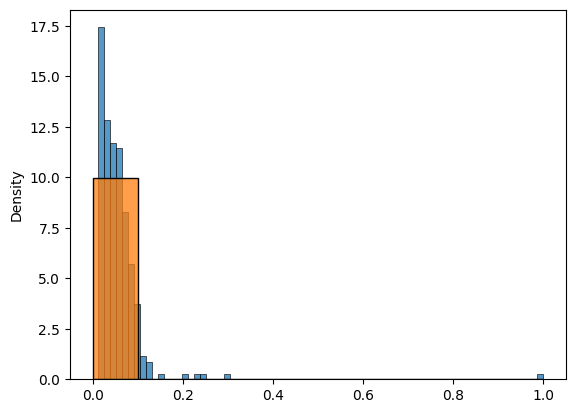

In [168]:
# plt.plot(np.exp(np.linspace(-1,0)), np.quantile(minmax(baselines['MST_e']),np.exp(np.linspace(-1,0)) , method='inverted_cdf'))
# plt.plot(np.exp(np.linspace(-1,0)), np.quantile(minmax(baselines['sinkhornOTP']), np.exp(np.linspace(-1,0)), method='inverted_cdf'))
# plt.yscale('log')
sns.histplot(np.quantile(minmax(baselines['MST_e']),minmax(baselines['MST_e']) , method='inverted_cdf')[np.where(true)], stat='density')
sns.histplot(np.quantile(minmax(baselines['sinkhornOTP']),minmax(baselines['sinkhornOTP']), method='inverted_cdf')[np.where(true)], stat='density')
# plt.xscale('log')

# sns.kdeplot(ma.array(np.quantile(minmax(baselines['MST_e']),minmax(baselines['MST_e']) , method='median_unbiased')[np.where(1-true)]).filled(0.001))

# sns.histplot(baselines['MST_e'])
# np.quantile(minmax(baselines['MST_e']),minmax(baselines['MST_e']))[np.where(true)]
# np.quantile(minmax(baselines['sinkhornOTP']), np.exp(np.linspace(-1,0)), method='inverted_cdf')

In [169]:
sns.histplot(np.quantile(minmax(baselines['MST_e']),minmax(baselines['MST_e']) , method='median_unbiased')[np.where(1-true)]))
sns.kdeplot(ma.array(1-np.quantile(1-minmax(baselines['sinkhornOTP']),1-minmax(baselines['sinkhornOTP']) , method='median_unbiased')[np.where(1-true)]))
# np.quantile(minmax(baselines['sinkhornOTP']),minmax(baselines['sinkhornOTP']) , method='median_unbiased')[np.where(1-true)].sum()

SyntaxError: unmatched ')' (3734053502.py, line 1)

In [117]:
minmax(baselines['MST_i'])[np.where(1-true)]
# np.where(true)

array([0.00136569, 0.00121395, 0.        , ..., 0.        , 0.        ,
       0.        ])

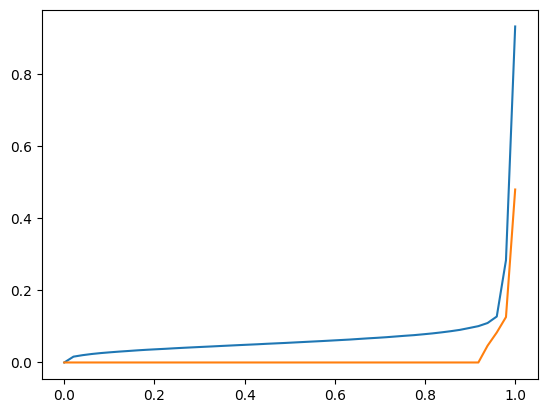

In [171]:
plt.plot(np.linspace(0,1),np.quantile(minmax(baselines['MST_e'])[np.where(1-true)], np.linspace(0,1), method='median_unbiased'))
plt.plot(np.linspace(0,1), np.quantile(minmax(baselines['sinkhornOTP'])[np.where(1-true)], np.linspace(0,1), method='median_unbiased'))


<Axes: ylabel='Count'>

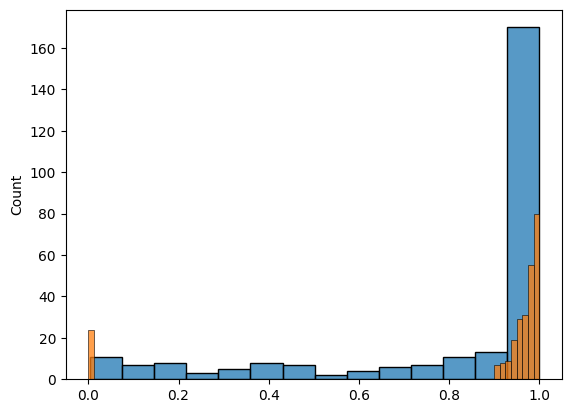

In [172]:
sns.histplot(percentileofscore(minmax(baselines['MST_e']), minmax(baselines['MST_e']), kind='strict')[np.where(true)]/100)
sns.histplot(percentileofscore(minmax(baselines['sinkhornOTP']), minmax(baselines['sinkhornOTP']), kind='strict')[np.where(true)]/100)#, name=lab, ax=plt.gca())   
# baselines['sinkhornOTP']/100